# PCA with K means

## Download data from CSD3 in case S3 bucket is offline
```bash
#!/bin/bash

# Define shot IDs
shot_ids=(23447 30005 30021 30421)

# Remote info
remote_alias="CSD3"
remote_dir="/rds/project/rds-mOlK9qn0PlQ/fairmast/upload-tmp/level2"

# Loop through each shot_id and use rsync to download
for shot_id in "${shot_ids[@]}"; do
    echo "Downloading ${shot_id}.zarr from ${remote_alias}..."
    rsync -avz "${remote_alias}:${remote_dir}/${shot_id}.zarr" ./
done

echo "All downloads complete."
```

In [1]:
# Denoising
import zarr
import zarr.storage
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from scipy.signal import stft
from scipy.signal import find_peaks
from collections import defaultdict
from scipy.ndimage import median_filter, gaussian_filter
from skimage import measure
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pathlib import Path
from scipy.signal import savgol_filter

In [2]:
# List of shot IDs
shot_ids = [23447, 30005, 30021, 30421]  # Add more as needed

# S3 endpoint
endpoint = "https://s3.echo.stfc.ac.uk"
fs = fsspec.filesystem(
    protocol='simplecache',
    target_protocol="s3",
    target_options=dict(anon=True, endpoint_url=endpoint)
)

In [3]:
store_list = []
zgroup_list = []

# Loop through each shot ID
for shot_id in shot_ids:
    path = Path(f"shots/{shot_id}.zarr")

    if not path.exists():
        print(f"Local path {path} not found.")
        continue

    store = zarr.DirectoryStore(str(path))
    store_list.append(store)

    try:
        zgroup = zarr.open(store, mode='r')
        zgroup_list.append(zgroup)
        print(f"Loaded shot ID {shot_id}")
        # Example: print available array keys
        # print(list(zgroup.array_keys()))
    except Exception as e:
        print(f"Failed to load shot ID {shot_id}: {e}")

Loaded shot ID 23447
Loaded shot ID 30005
Loaded shot ID 30021
Loaded shot ID 30421


In [4]:
# DOWNLOAD FROM S3 BUCKET
# store_list = []
# zgroup_list = []

# # Loop through each shot ID
# for shot_id in shot_ids:
#     url = f"s3://mast/level2/shots/{shot_id}.zarr"
    
#     store = zarr.storage.FSStore(fs=fs, url=url)
#     store_list.append(store)
#     # open or download the Zarr group
#     try:
#         zgroup_list.append(zarr.open(store, mode='r'))
#         print(f"Loaded shot ID {shot_id}")
#         # Do something with zgroup here, like listing arrays:
#         # print(list(zgroup.array_keys()))
#     except Exception as e:
#         print(f"Failed to load shot ID {shot_id}: {e}")

In [5]:
mirnov = [xr.open_zarr(store, group="magnetics") for store in store_list]
ds_list = [m['b_field_pol_probe_omv_voltage'].isel(b_field_pol_probe_omv_channel=1) for m in mirnov]

## STFT or short time fourier transform

In [6]:
def plot_stft_spectrogram(    ds,    shot_id=None,    nperseg=2000,    nfft=2000,    tmin=0.1,    tmax=0.46,    fmax_kHz=50,    cmap='jet'):
    """
    Plot STFT spectrogram for a given xarray DataArray `ds`.
    
    Parameters:
    - ds: xarray.DataArray with a 'time_mirnov' coordinate.
    - shot_id: Optional shot ID for labeling.
    - nperseg: Number of points per STFT segment.
    - nfft: Number of FFT points.
    - tmin, tmax: Time range to display (seconds).
    - fmax_kHz: Max frequency to display (kHz).
    - cmap: Colormap name.
    """
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap(cmap, 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, fmax_kHz)
    #ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    title = f"STFT Spectrogram"
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label='Amplitude')
    plt.tight_layout()

[None, None, None, None]

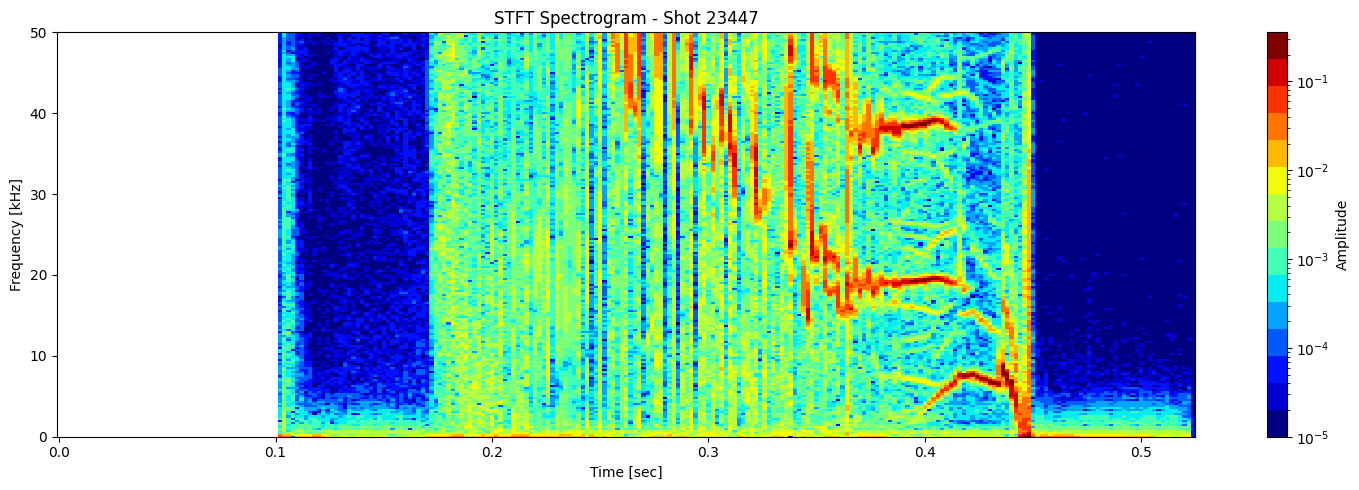

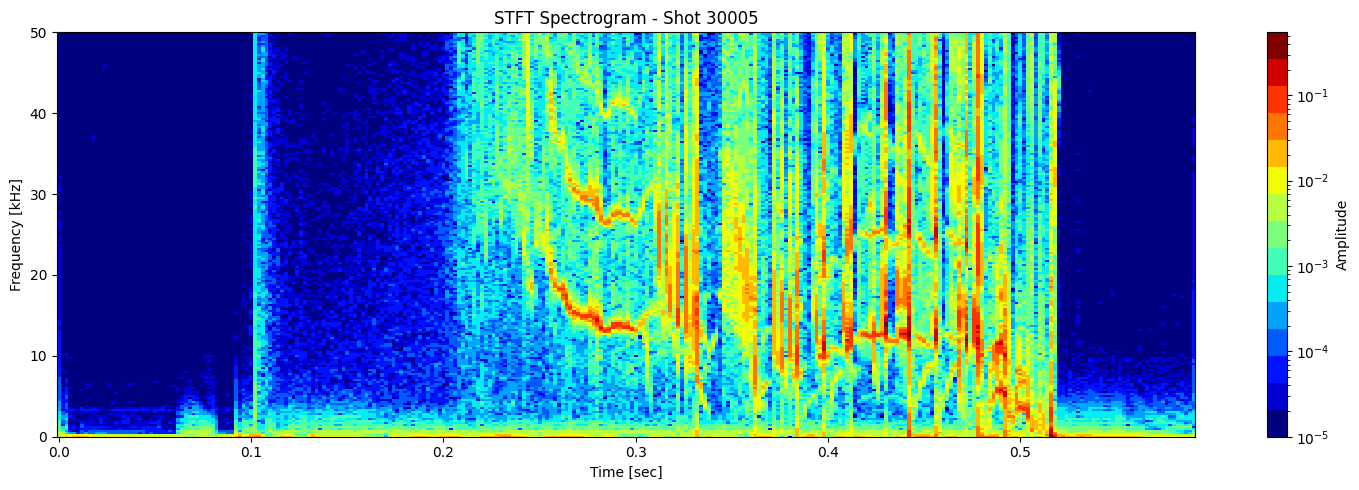

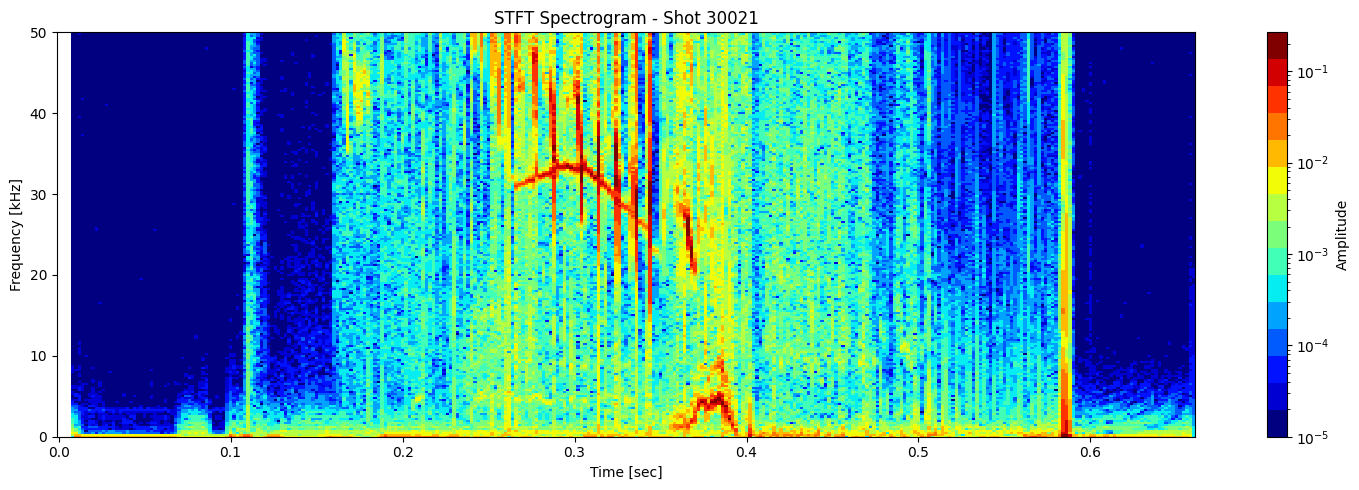

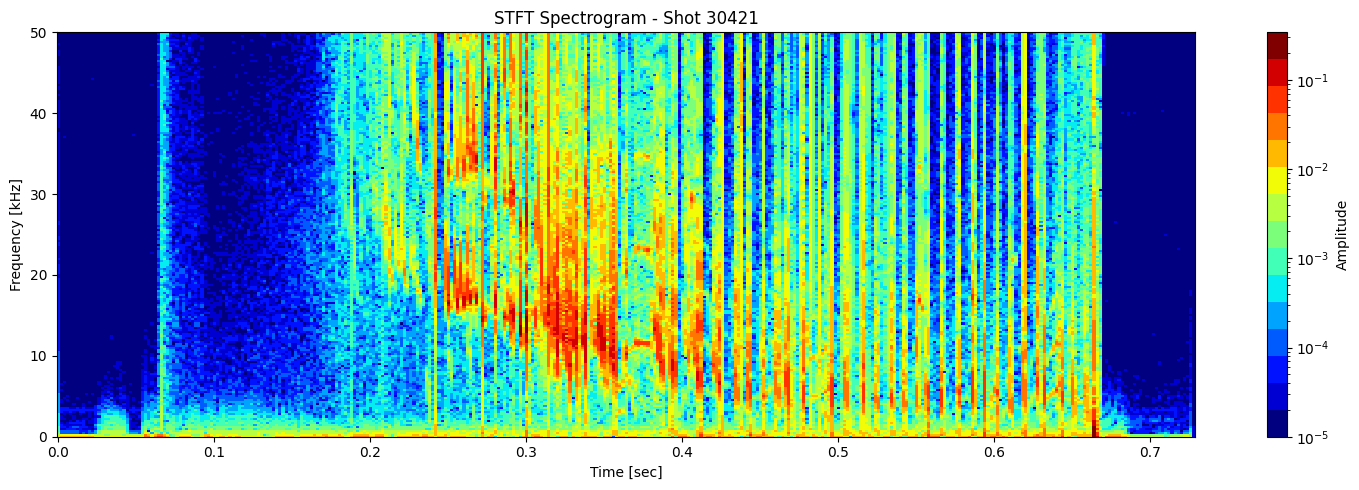

In [7]:
[plot_stft_spectrogram(ds_list[i], shot_ids[i]) for i in range(len(ds_list))]

## Thresholding based on percentage

In [8]:
def plot_amplitude_masking(ds, shot_id=None, nperseg=2000, nfft=2000,
                           sigma=1.0, apply_gaussian=False, apply_mask=True,
                           mask_percentile=60, use_percentage=True,
                           tmin=0.1, tmax=0.46, fmax_kHz=50, cmap='jet', apply_savgol_filter = False):
    """
    Plots the STFT spectrogram with optional Gaussian blur and masking. This is one function doing everything. No helper needed.

    Parameters:
    - ds: xarray.DataArray with 'time_mirnov'
    - shot_id: Optional shot ID
    - apply_gaussian: Whether to apply Gaussian blur
    - apply_mask: Whether to apply masking
    - mask_percentile: If use_percentage=True, keep top X% of points.
                       Else, mask values below the Xth percentile.
    - use_percentage: Use percentage thresholding instead of percentile
    """

    # Compute STFT
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)
    magnitude = np.abs(Zxx)  # Take magnitude of complex STFT

    # Optional Gaussian blur (for smoothing the spectrogram)
    if apply_gaussian:
        magnitude = gaussian_filter(magnitude, sigma=sigma)

    # savgol filter
    if apply_savgol_filter:
        # windows length Must be an odd integer.
        # 
        window_length = max(5, min(11, len(f) // 3 * 2 + 1))
        magnitude = savgol_filter(magnitude, window_length=7, polyorder=2)

    # Clip negative values just in case blur introduced due to skewed data like sharp gradients
    magnitude = np.clip(magnitude, 0, None)

    # Apply masking
    if apply_mask:
        if use_percentage:
            # Flatten and sort finite values to find cutoff for top X% values
            valid = magnitude[np.isfinite(magnitude)].flatten()
            if valid.size > 0:
                sorted_vals = np.sort(valid)
                cut_index = int((1 - mask_percentile / 100) * len(sorted_vals))
                cutoff_value = sorted_vals[cut_index]
                # Mask all values below cutoff
                magnitude = np.where(magnitude >= cutoff_value, magnitude, np.nan)
        else:
            # Use standard percentile-based thresholding
            threshold = np.percentile(magnitude, mask_percentile)
            magnitude = np.where(magnitude >= threshold, magnitude, np.nan)

    # save a copy of the segmented spectrogram
    segmented_stft = magnitude.copy()


    # Skip if everything got masked (to avoid plotting empty images)
    if not np.any(np.isfinite(magnitude)):
        print(f"Shot {shot_id} — all values masked. Skipping plot.")
        return

    # Plot the spectrogram
    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, magnitude,
        shading='nearest',
        cmap=plt.get_cmap(cmap, 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, fmax_kHz)
    #ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    title = f"Filtered STFT - Shot {shot_id}" if shot_id else "Filtered STFT"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label='Amplitude')
    plt.tight_layout()

    return t, f, segmented_stft, Zxx


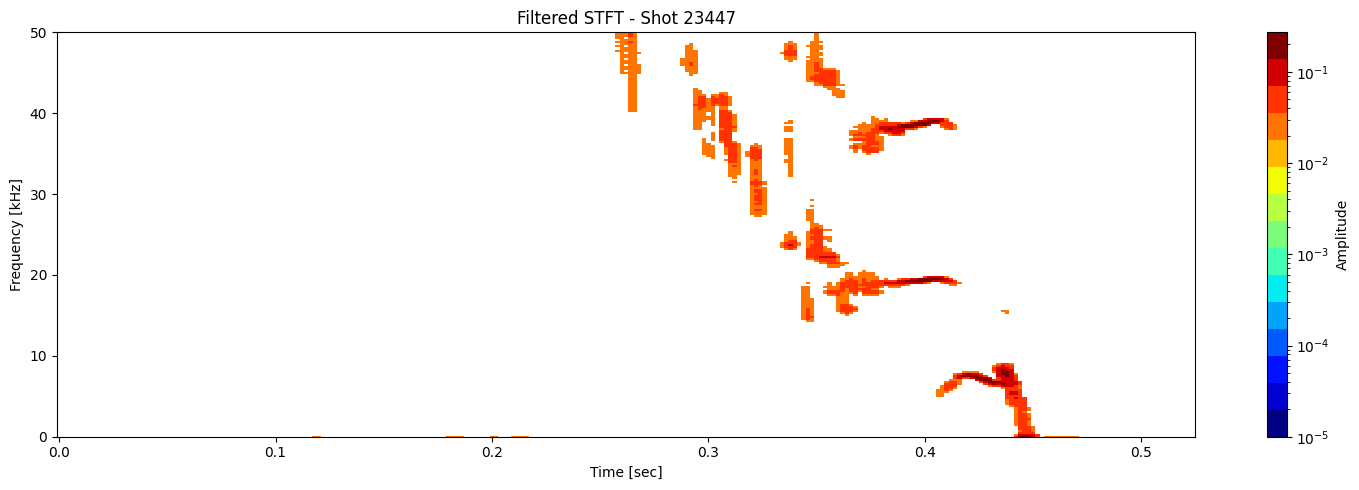

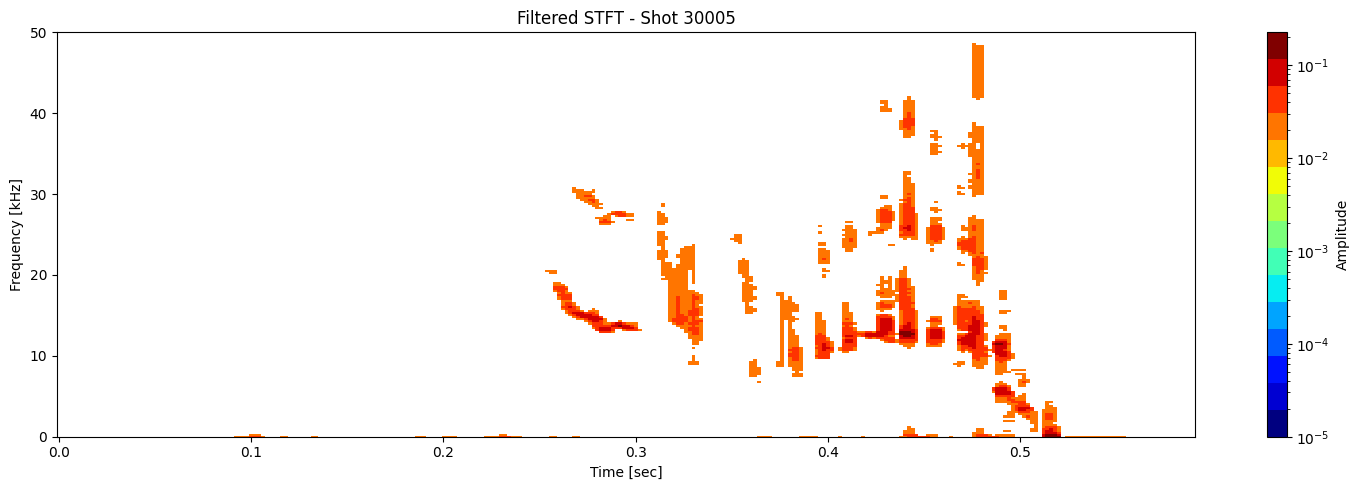

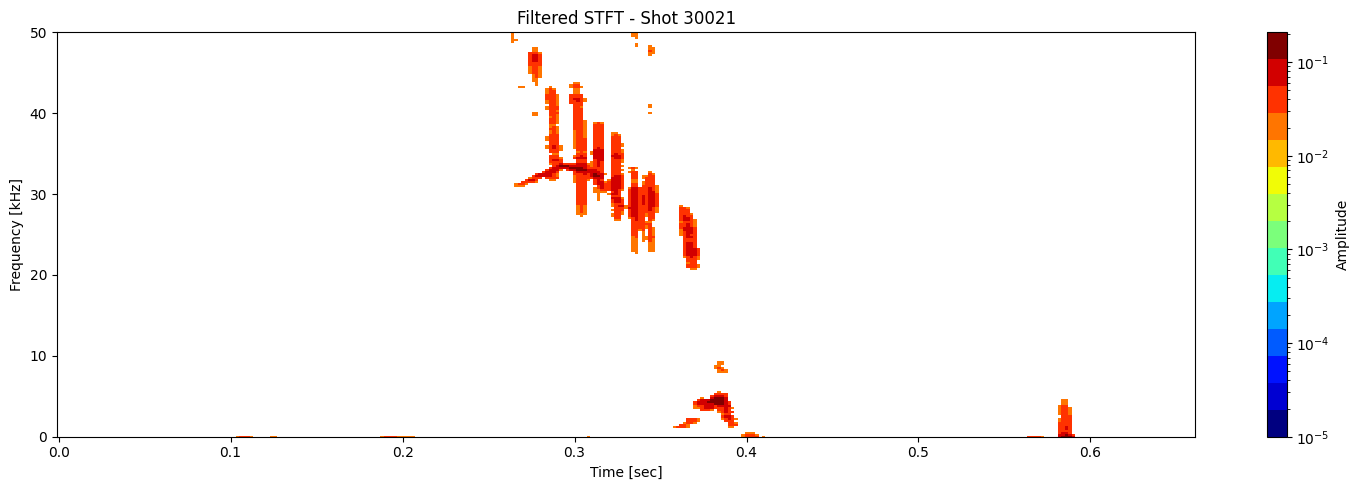

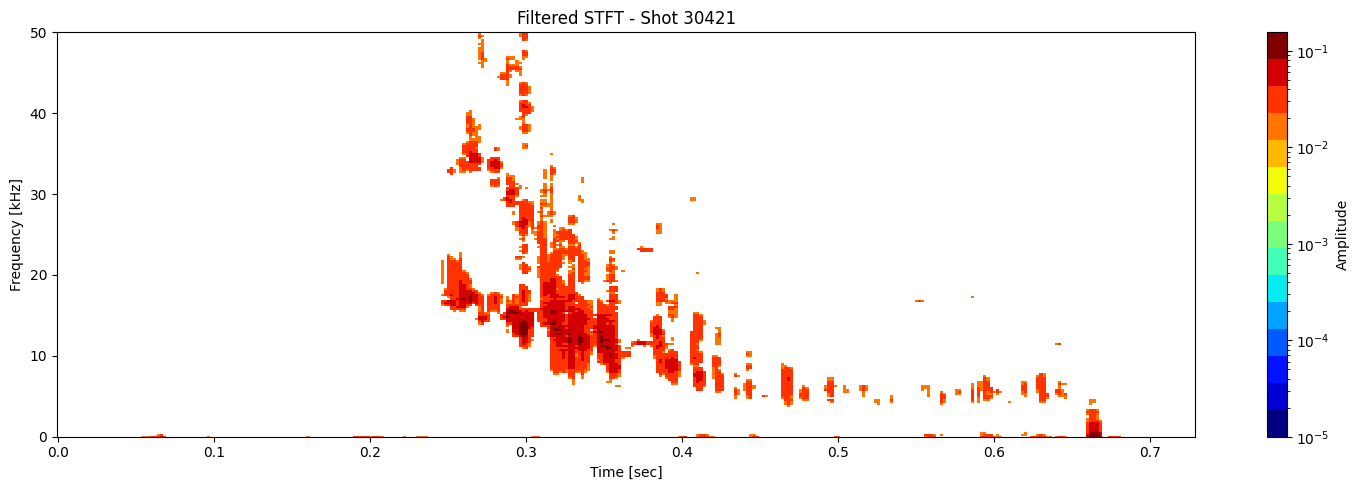

In [9]:
results = [plot_amplitude_masking(ds_list[i], shot_ids[i], mask_percentile=1, sigma=0.9, apply_gaussian=False, apply_savgol_filter=True) for i in range(len(ds_list))]
t_list, f_list, seg_list, Zxx_list = zip(*results)

## Contour detection

In [10]:
def plot_spectrogram_with_contours(Zxx, f, t, contours, shot_id=None, vmin=1e-5):

    f_kHz = f / 1000

    fig, ax = plt.subplots(figsize=(12, 5))
    cax = ax.pcolormesh(t, f_kHz, np.abs(Zxx), shading='nearest',
                        norm=LogNorm(vmin=vmin), cmap='jet')

    for contour in contours:
        ax.plot(t[np.clip(contour[:, 1].astype(int), 0, len(t) - 1)],
                f_kHz[np.clip(contour[:, 0].astype(int), 0, len(f) - 1)],
                color='black', lw=0.5)


    ax.set_ylim(0, 70)
    #ax.set_xlim(0.1, 0.46)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Frequency [kHz]')
    title = "STFT with Contour Overlay"
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label="Amplitude")
    plt.grid(True)
    plt.tight_layout()

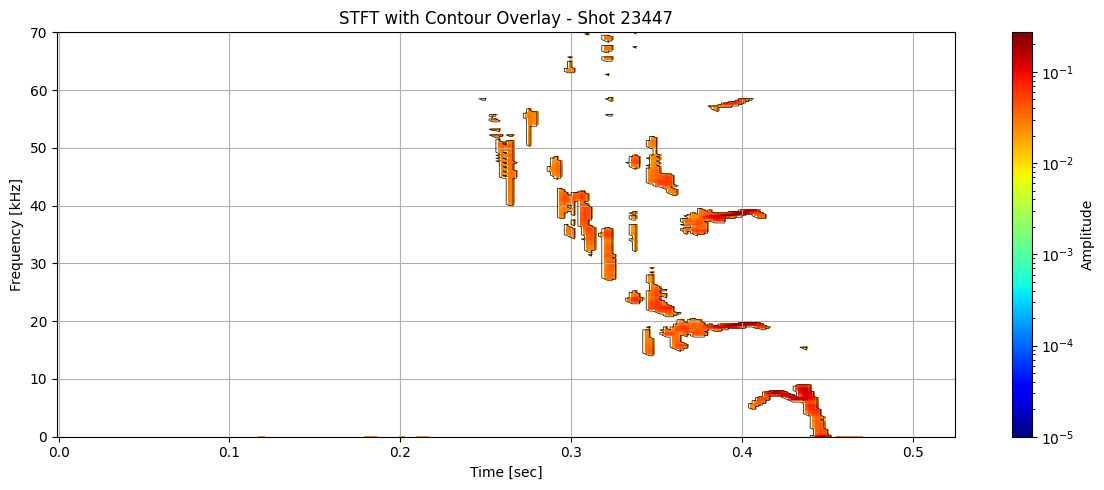

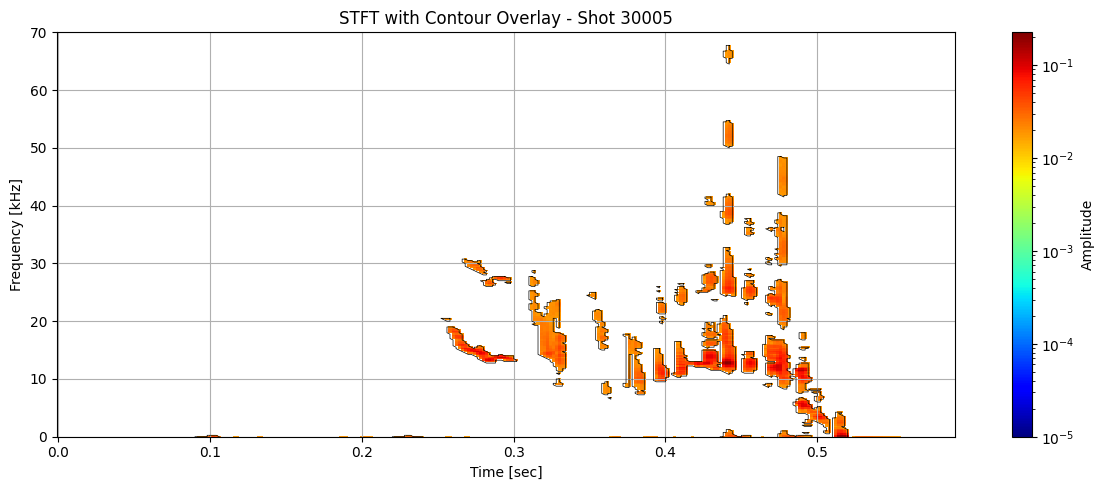

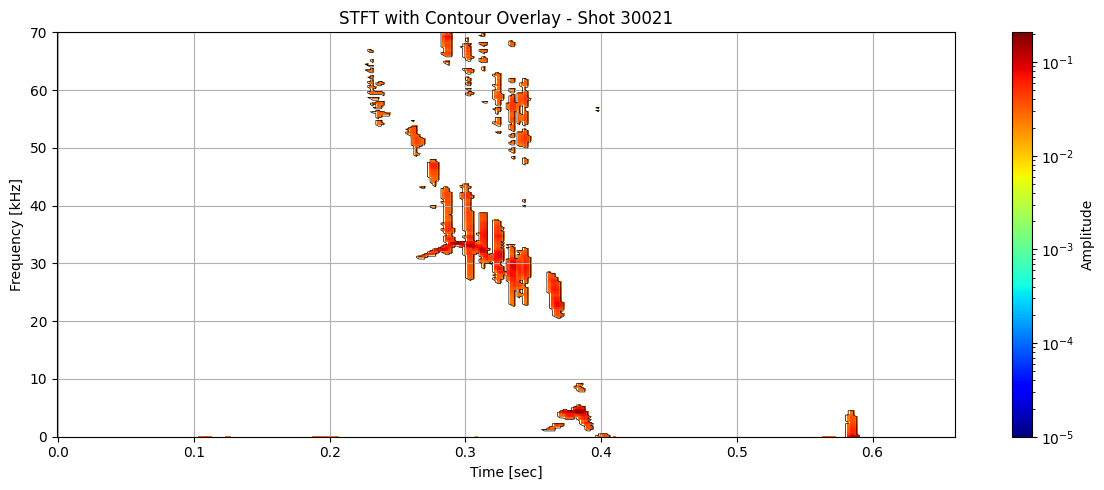

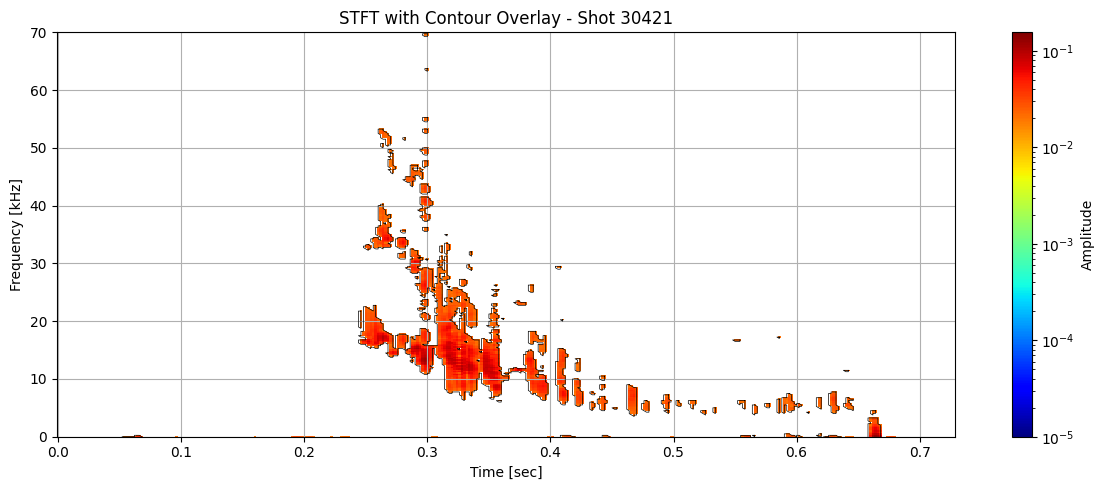

In [11]:
for i in range(len(ds_list)):
    # Use masked STFT (seg_list[i]) to extract binary mask
    binary_mask = np.isfinite(seg_list[i]).astype(float)
    # Get contours at 0.5 (standard threshold for binary masks)
    contours = measure.find_contours(binary_mask, level=0.5)
    plot_spectrogram_with_contours(seg_list[i], f_list[i], t_list[i], contours, shot_id=shot_ids[i])


## Extract information about each contour

In [12]:
def extract_contour_features(contour, t, f, Zxx):
    """Extract features from a single contour."""
    time_idx = np.clip(contour[:, 1].astype(int), 0, len(t) - 1)
    freq_idx = np.clip(contour[:, 0].astype(int), 0, len(f) - 1)
    
    times = t[time_idx]
    freqs = f[freq_idx]# / 1000  # in kHz
    amps = np.abs(Zxx[freq_idx, time_idx])
    
    # Handle degenerate contours
    if len(times) < 2:
        return None
    
    # Features
    duration = times.max() - times.min()
    freq_span = freqs.max() - freqs.min()
    slope = np.polyfit(times, freqs, 1)[0]
    avg_amp = np.mean(amps)
    max_amp = np.max(amps)
    
    return {
        'duration': duration,
        'freq_span': freq_span,
        'slope': slope,
        'avg_amp': avg_amp,
        'max_amp': max_amp,
        'start_time': times.min(),
        'end_time': times.max(),
        'start_freq': freqs[0],
        'end_freq': freqs[-1],
        'length': len(times),
    }


In [13]:
# Initialize a list to collect all feature DataFrames
all_feature_dfs = []
# Extract features from all contours
# Loop through each shot to extract contour features
for i in range(len(ds_list)):
    #  Binary mask from segmented STFT (NaNs were introduced during masking)
    binary_mask = np.isfinite(seg_list[i]).astype(float)

    #  Detect contours at 0.5 level (standard threshold for binary masks)
    contours = measure.find_contours(binary_mask, level=0.5)

    # #  Extract features for each contour using helper
    # features = [extract_contour_features(c, t_list[i], f_list[i], Zxx_list[i]) for c in contours]

    # #  Filter out any invalid results (None entries)
    # features = [f for f in features if f is not None]

    # for f in features:
    #     f['shot_id'] = shot_ids[i]  # Add shot ID to each feature dict
    
    features = []
    for j, c in enumerate(contours):  # add j for contour index
        feat = extract_contour_features(c, t_list[i], f_list[i], Zxx_list[i])
        if feat is not None:
            feat['shot_id'] = shot_ids[i]
            feat['contour_idx'] = j       
            features.append(feat)

    all_feature_dfs.extend(features)

# Concatenate into a single DataFrame
df_all = pd.DataFrame(all_feature_dfs)

In [14]:
df_all.head()

,duration,freq_span,slope,avg_amp,max_amp,start_time,end_time,start_freq,end_freq,length,shot_id,contour_idx
0,0.004,0.000,0.000000,0.023028,0.024961,0.116000,0.120000,0.0,0.0,4,23447,0
1,0.008,0.000,0.000000,0.025997,0.033559,0.178000,0.186000,0.0,0.0,6,23447,1
2,0.004,0.000,0.000000,0.021432,0.024144,0.198000,0.202000,0.0,0.0,4,23447,2
3,0.008,0.000,0.000000,0.021969,0.025508,0.208000,0.216000,0.0,0.0,6,23447,3
4,0.048,8999.982,-85343.955436,0.012600,0.110189,0.404001,0.452001,0.0,0.0,148,23447,4


In [15]:
df_clean = df_all.dropna()

###### More filtering needed. A lot of garbage contour still left #######
df_clean = df_clean[(df_clean['duration'] > 0.004) & 
                    (df_clean['avg_amp'] > 1e-4) &
                    (df_clean['length'] >= 5)&
                    (df_clean['freq_span'] > 0.1) &
                    (np.abs(df_clean['slope']) < 5e4)]

# select all rows with shot_id 23447
df_clean[df_clean['shot_id'] == 23447].head()

,duration,freq_span,slope,avg_amp,max_amp,start_time,end_time,start_freq,end_freq,length,shot_id,contour_idx
7,0.064,5749.9885,30710.906079,0.023135,0.156930,0.352001,0.416001,20499.9590,20499.9590,145,23447,7
8,0.004,499.9990,-23026.223684,0.030197,0.046078,0.434001,0.438001,15499.9690,15499.9690,9,23447,8
11,0.010,2249.9955,-5161.559246,0.013658,0.051164,0.332001,0.342001,25249.9495,25249.9495,29,23447,11
19,0.050,4749.9905,43065.864199,0.021728,0.149185,0.364001,0.414001,39499.9210,39499.9210,121,23447,19
21,0.004,749.9985,4166.650000,0.031503,0.057582,0.334001,0.338001,38249.9235,38249.9235,11,23447,21


In [16]:
len(df_clean)

261

In [17]:
df_clean.describe()

,duration,freq_span,slope,avg_amp,max_amp,start_time,end_time,start_freq,end_freq,length,shot_id,contour_idx
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.00000
mean,0.006690,1160.917218,-864.429527,0.022488,0.049807,0.345472,0.352162,57955.822785,57955.822785,17.896552,29098.823755,78.94636
std,0.005537,1244.587927,19341.970055,0.006750,0.015256,0.091565,0.091794,34317.698029,34317.698029,17.018113,2414.595628,52.03258
min,0.004000,249.999500,-48348.863208,0.005850,0.024897,0.052000,0.068000,0.000000,0.000000,7.000000,23447.000000,0.00000
25%,0.004000,499.999000,-10445.163699,0.018000,0.039058,0.294001,0.302001,25999.948000,25999.948000,9.000000,30005.000000,38.00000
50%,0.006000,749.998500,-3348.200893,0.022258,0.049379,0.320001,0.324001,63749.872500,63749.872500,13.000000,30021.000000,68.00000
75%,0.008000,1249.997500,8928.535714,0.026734,0.057717,0.380001,0.384001,87999.824000,87999.824000,19.000000,30021.000000,108.00000
max,0.064000,7749.984500,48275.668966,0.038196,0.156930,0.660001,0.668001,138749.722500,138749.722500,145.000000,30421.000000,209.00000


## PCA

In [18]:
features_for_pca = df_clean[[
    'duration',
    'freq_span',
    'slope',
    'avg_amp',
    'max_amp',
    'length',
    'start_time',
    'end_time',
    'start_freq',
    'end_freq'
    # add 'start_time', 'end_time', etc. if you want temporal position in clustering
]]

In [19]:
X_scaled = StandardScaler().fit_transform(features_for_pca)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

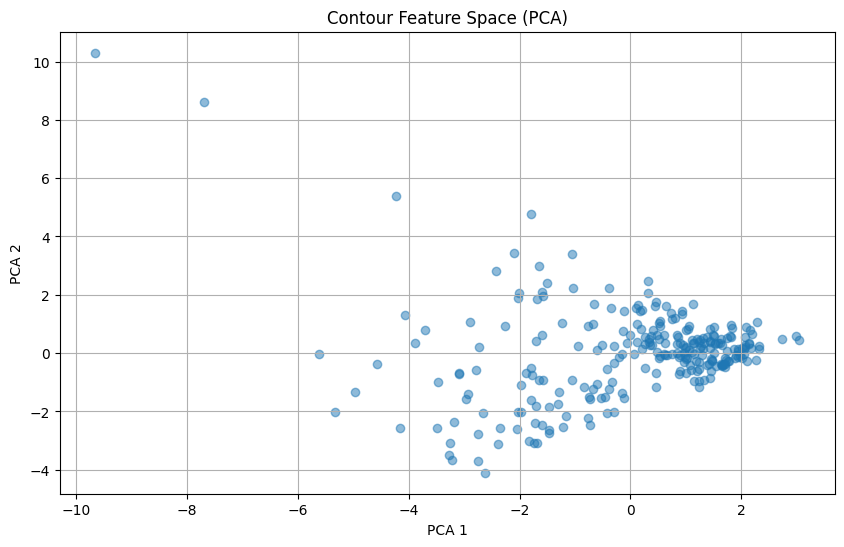

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Contour Feature Space (PCA)")
plt.grid(True)

In [21]:
pca.components_  # Rows are PCs, columns are original features


array([[-0.30448631, -0.33932833, -0.04914475,  0.2417678 , -0.2029942 ,
        -0.35094409, -0.34756518, -0.36506315,  0.39549744,  0.39549744],
       [ 0.37581452,  0.34228755,  0.11716779, -0.03324786,  0.36578401,
         0.43375828, -0.36790736, -0.34431705,  0.27469504,  0.27469504]])

## Simple clustering

In [22]:
#from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [23]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)


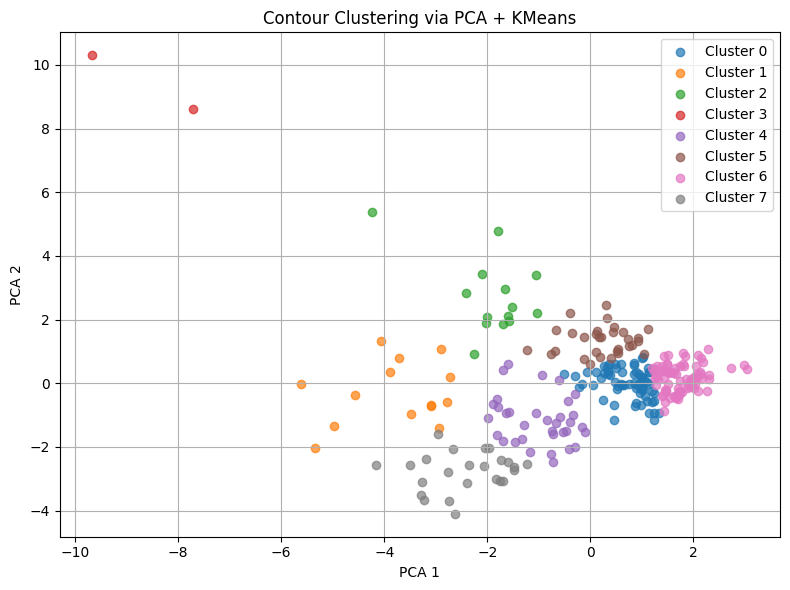

In [24]:
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    mask = cluster_labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f"Cluster {i}", alpha=0.7)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Contour Clustering via PCA + KMeans")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [25]:
df_clean['cluster'] = cluster_labels

/tmp/ipykernel_13399/3660331428.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_clusters)


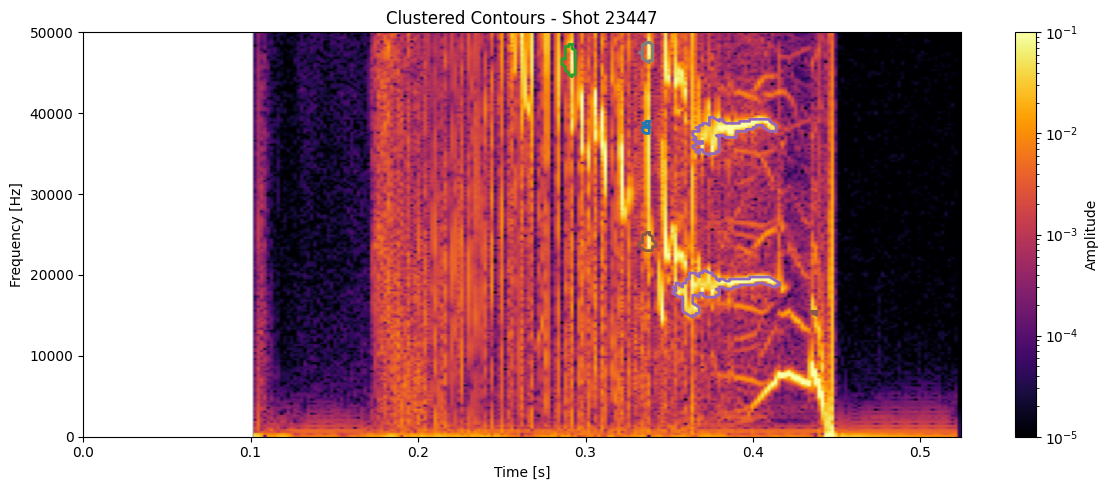

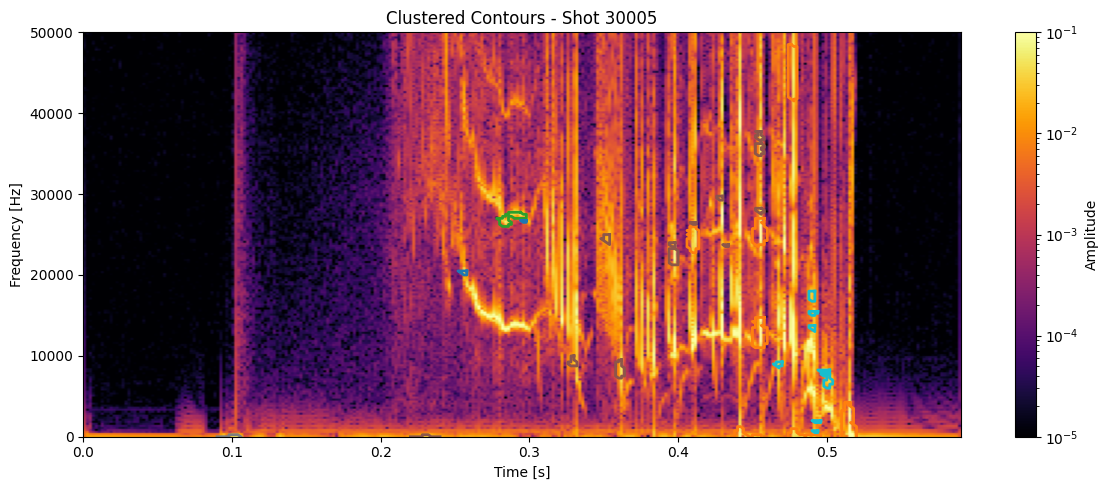

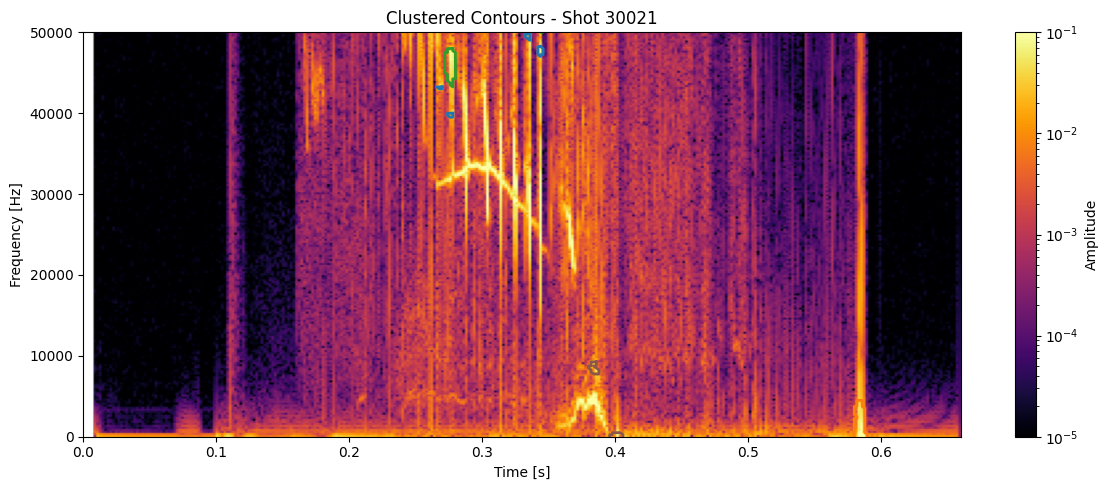

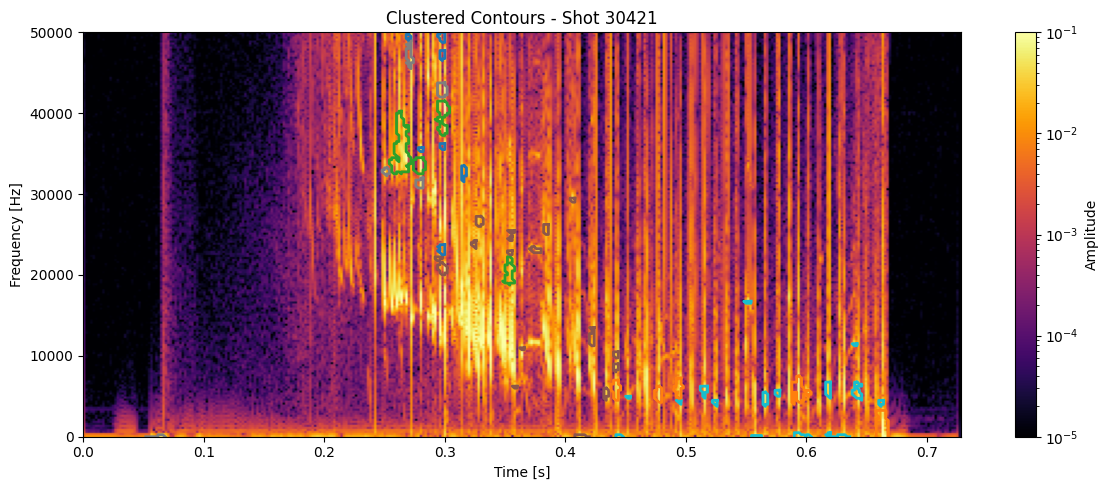

In [28]:
num_clusters = df_clean['cluster'].nunique()
colors = cm.get_cmap('tab10', num_clusters)

for shot_id in df_clean['shot_id'].unique():
    # Pull the STFT and metadata for this shot
    idx = shot_ids.index(shot_id)
    #Z = ds_list[idx]
    Z = np.abs(Zxx_list[idx]) 
    t = t_list[idx]
    f = f_list[idx]

    # Get contours and cluster labels for this shot
    df_shot = df_clean[df_clean['shot_id'] == shot_id]
    contours = measure.find_contours(np.isfinite(seg_list[idx]).astype(float), 0.5)

    plt.figure(figsize=(12, 5))
    plt.imshow(
        np.abs(Zxx_list[idx]),
        aspect='auto', origin='lower',
        extent=[t[0], t[-1], f[0], f[-1]],
        cmap='inferno', norm=LogNorm(vmin=1e-5, vmax=1e-1)
    )
    # for _, row in df_shot.iterrows():
    #     # Reconstruct a line segment if you still have contours
    #     #c = measure.find_contours(np.isfinite(seg_list[idx]).astype(float), 0.5)[int(row.name)]
    #     c = contours[int(row['contour_idx'])] 
    #     plt.plot(t[c[:, 1].astype(int)], f[c[:, 0].astype(int)], 
    #              color=colors(row['cluster']), linewidth=2)

    for _, row in df_shot.iterrows():
        contour = contours[int(row['contour_idx'])]     # this links to clustering
        t_pts = t[contour[:, 1].astype(int)]
        f_pts = f[contour[:, 0].astype(int)]
        plt.plot(t_pts, f_pts, color=colors(int(row['cluster'])), linewidth=2)

    plt.colorbar(label='Amplitude')
    plt.title(f"Clustered Contours - Shot {shot_id}")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.ylim(0, 50000)
    plt.tight_layout()
    plt.show()